In [4]:
# Preprocessing du dataset Sleep-EDF
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pyedflib
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
import warnings
warnings.filterwarnings('ignore')

# Config
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print(" Imports OK!")
print(f" Dossier actuel: {Path.cwd()}")

 Imports OK!
 Dossier actuel: /Users/marinedeldicque/Documents/sleepai/notebooks


In [5]:
# Paramètres du preprocessing
PARAMS = {
    'sampling_rate': 100,      # Hz
    'epoch_duration': 30,       # secondes
    'lowcut': 0.3,             # Hz - filtre passe-haut
    'highcut': 35.0,           # Hz - filtre passe-bas
    'filter_order': 5,
    'test_size': 0.15,
    'val_size': 0.176          # 15% du total (15/85)
}

# Mapping des stades
STAGE_MAPPING = {
    'Sleep stage W': 0,  # Wake
    'Sleep stage 1': 1,  # N1
    'Sleep stage 2': 2,  # N2
    'Sleep stage 3': 3,  # N3
    'Sleep stage 4': 3,  # N4 → N3
    'Sleep stage R': 4,  # REM
    'Sleep stage ?': -1, # Exclure
    'Movement time': -1  # Exclure
}

STAGE_NAMES = ['Wake', 'N1', 'N2', 'N3', 'REM']

print(" Paramètres configurés:")
for key, val in PARAMS.items():
    print(f"   {key}: {val}")

 Paramètres configurés:
   sampling_rate: 100
   epoch_duration: 30
   lowcut: 0.3
   highcut: 35.0
   filter_order: 5
   test_size: 0.15
   val_size: 0.176


In [6]:
# Fonctions de traitement du signal
def butter_bandpass(lowcut, highcut, fs, order=5):
    """Crée un filtre passe-bande Butterworth"""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut, highcut, fs, order=5):
    """Applique un filtre passe-bande"""
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    filtered = signal.filtfilt(b, a, data)
    return filtered

# Test du filtre
test_signal = np.random.randn(3000)  # 30s à 100Hz
filtered_test = apply_bandpass_filter(test_signal, 0.3, 35, 100)

print(" Fonctions de filtrage définies et testées")

 Fonctions de filtrage définies et testées


In [7]:
# Charger tous les enregistrements
data_dir = Path('../data/raw')

# Fonction pour extraire ID
def extract_base_id(filename):
    return filename.stem[:6]

# Lister les fichiers
psg_files = sorted(data_dir.glob("*-PSG.edf"))
hypno_files = sorted(data_dir.glob("*-Hypnogram.edf"))

psg_base_ids = {extract_base_id(f): f for f in psg_files}
hypno_base_ids = {extract_base_id(f): f for f in hypno_files}

complete_ids = sorted(set(psg_base_ids.keys()) & set(hypno_base_ids.keys()))

complete_pairs = {
    base_id: {
        'psg': psg_base_ids[base_id],
        'hypno': hypno_base_ids[base_id]
    }
    for base_id in complete_ids
}

print(f" {len(complete_ids)} paires complètes chargées")

 28 paires complètes chargées


In [8]:
def process_single_recording(base_id, pair_dict):
    """
    Traite un enregistrement complet : PSG + Hypnogramme
    
    Returns:
        epochs: array (n_epochs, 3000) - époques de 30s filtrées
        labels: array (n_epochs,) - labels des stades
    """
    psg_file = pair_dict['psg']
    hypno_file = pair_dict['hypno']
    
    # 1. Charger PSG
    with pyedflib.EdfReader(str(psg_file)) as f:
        eeg_signal = f.readSignal(0)  # Canal 0: Fpz-Cz
        psg_duration = f.getFileDuration()
    
    # 2. Filtrer le signal
    filtered_signal = apply_bandpass_filter(
        eeg_signal, 
        PARAMS['lowcut'], 
        PARAMS['highcut'], 
        PARAMS['sampling_rate'],
        PARAMS['filter_order']
    )
    
    # 3. Charger annotations
    with pyedflib.EdfReader(str(hypno_file)) as f:
        annotations = f.readAnnotations()
    
    # 4. Créer époques et labels
    epochs_list = []
    labels_list = []
    
    epoch_samples = PARAMS['sampling_rate'] * PARAMS['epoch_duration']
    
    for onset, duration, description in zip(*annotations):
        # Mapper le stade
        stage = STAGE_MAPPING.get(description, -1)
        
        # Exclure les stades inconnus
        if stage == -1:
            continue
        
        # Vérifier que l'annotation est dans le signal
        if onset + duration > psg_duration:
            continue
        
        # Extraire l'époque
        start_idx = int(onset * PARAMS['sampling_rate'])
        end_idx = int(start_idx + epoch_samples)
        
        # Vérifier la longueur
        if end_idx > len(filtered_signal):
            continue
        
        epoch = filtered_signal[start_idx:end_idx]
        
        # Vérifier que c'est exactement 3000 samples
        if len(epoch) == epoch_samples:
            epochs_list.append(epoch)
            labels_list.append(stage)
    
    return np.array(epochs_list), np.array(labels_list)

print(" Fonction de traitement définie")

 Fonction de traitement définie


In [9]:
# Traiter tous les enregistrements
print("🔄 Traitement de tous les enregistrements...")
print("-" * 60)

all_epochs = []
all_labels = []

for i, base_id in enumerate(complete_ids, 1):
    try:
        epochs, labels = process_single_recording(base_id, complete_pairs[base_id])
        
        all_epochs.append(epochs)
        all_labels.append(labels)
        
        print(f"✅ {i:2d}/{len(complete_ids)} {base_id}: {len(epochs):4d} époques")
        
    except Exception as e:
        print(f" {i:2d}/{len(complete_ids)} {base_id}: Erreur - {e}")

# Concaténer
X = np.vstack(all_epochs)
y = np.concatenate(all_labels)

print("\n" + "=" * 60)
print(f" Traitement terminé!")
print(f" Dataset complet:")
print(f"   Shape X: {X.shape}")
print(f"   Shape y: {y.shape}")
print(f"   Mémoire: {X.nbytes / 1e9:.2f} GB")

🔄 Traitement de tous les enregistrements...
------------------------------------------------------------
✅  1/28 SC4001:  153 époques
✅  2/28 SC4002:  150 époques
✅  3/28 SC4011:  125 époques
✅  4/28 SC4012:  170 époques
✅  5/28 SC4021:  160 époques
✅  6/28 SC4022:  177 époques
✅  7/28 SC4031:  118 époques
✅  8/28 SC4041:  159 époques
✅  9/28 SC4042:  173 époques
✅ 10/28 SC4051:  129 époques
✅ 11/28 SC4052:  136 époques
✅ 12/28 SC4061:   77 époques
✅ 13/28 SC4062:   97 époques
✅ 14/28 SC4071:  115 époques
✅ 15/28 SC4072:  178 époques
✅ 16/28 SC4081:  141 époques
✅ 17/28 SC4082:  155 époques
✅ 18/28 SC4091:  137 époques
✅ 19/28 SC4092:  103 époques
✅ 20/28 SC4101:   61 époques
✅ 21/28 SC4102:  116 époques
✅ 22/28 SC4111:  124 époques
✅ 23/28 SC4112:  125 époques
✅ 24/28 SC4121:  127 époques
✅ 25/28 SC4131:  146 époques
✅ 26/28 SC4141:  121 époques
✅ 27/28 SC4142:  123 époques
✅ 28/28 SC4151:   94 époques

 Traitement terminé!
 Dataset complet:
   Shape X: (3690, 3000)
   Shape y: (3690,


 Distribution des classes AVANT équilibrage:
------------------------------------------------------------
   Wake    :    382 ( 10.4%)
   N1      :    750 ( 20.3%)
   N2      :   1152 ( 31.2%)
   N3      :   1102 ( 29.9%)
   REM     :    304 (  8.2%)


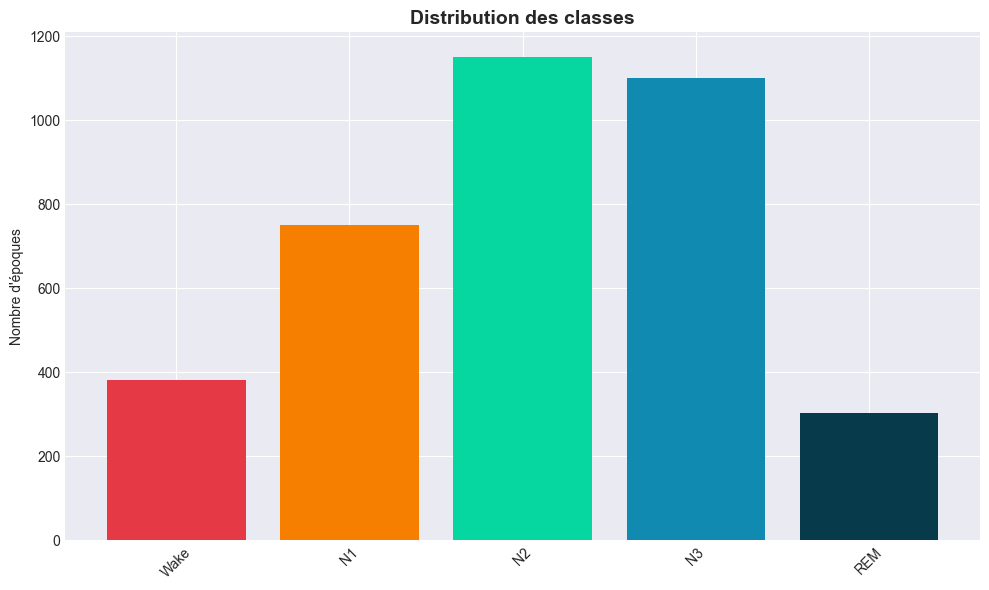

In [10]:
# Vérifier la distribution
print("\n Distribution des classes AVANT équilibrage:")
print("-" * 60)

unique, counts = np.unique(y, return_counts=True)
for stage_id, count in zip(unique, counts):
    percentage = (count / len(y)) * 100
    print(f"   {STAGE_NAMES[stage_id]:8s}: {count:6d} ({percentage:5.1f}%)")

# Visualiser
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([STAGE_NAMES[i] for i in unique], counts, 
       color=['#E63946', '#F77F00', '#06D6A0', '#118AB2', '#073B4C'])
ax.set_title('Distribution des classes', fontsize=14, fontweight='bold')
ax.set_ylabel('Nombre d\'époques')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Normaliser chaque époque individuellement (z-score)
print("\n Normalisation (z-score par époque)...")

X_normalized = np.zeros_like(X)

for i in range(len(X)):
    mean = X[i].mean()
    std = X[i].std()
    if std > 0:
        X_normalized[i] = (X[i] - mean) / std
    else:
        X_normalized[i] = X[i] - mean

print(f" Normalisation terminée")
print(f"   Mean global: {X_normalized.mean():.6f}")
print(f"   Std global: {X_normalized.std():.3f}")


 Normalisation (z-score par époque)...
 Normalisation terminée
   Mean global: 0.000000
   Std global: 1.000


In [13]:
# Split stratifié
print("\n  Séparation Train / Val / Test...")

# D'abord train+val / test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_normalized, y,
    test_size=PARAMS['test_size'],
    random_state=42,
    stratify=y
)

# Puis train / val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=PARAMS['val_size'],
    random_state=42,
    stratify=y_temp
)

print(f" Splits créés:")
print(f"   Train: {X_train.shape} ({len(y_train)/len(y)*100:.1f}%)")
print(f"   Val:   {X_val.shape} ({len(y_val)/len(y)*100:.1f}%)")
print(f"   Test:  {X_test.shape} ({len(y_test)/len(y)*100:.1f}%)")

# Vérifier distribution
for name, labels in [('Train', y_train), ('Val', y_val), ('Test', y_test)]:
    print(f"\n   {name}:")
    unique, counts = np.unique(labels, return_counts=True)
    for s_id, count in zip(unique, counts):
        print(f"      {STAGE_NAMES[s_id]}: {count}")


  Séparation Train / Val / Test...
 Splits créés:
   Train: (2584, 3000) (70.0%)
   Val:   (552, 3000) (15.0%)
   Test:  (554, 3000) (15.0%)

   Train:
      Wake: 268
      N1: 525
      N2: 807
      N3: 772
      REM: 212

   Val:
      Wake: 57
      N1: 112
      N2: 172
      N3: 165
      REM: 46

   Test:
      Wake: 57
      N1: 113
      N2: 173
      N3: 165
      REM: 46


In [14]:
# Sauvegarder les données prétraitées
output_dir = Path('../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

print("\n Sauvegarde...")

np.save(output_dir / 'X_train.npy', X_train)
np.save(output_dir / 'X_val.npy', X_val)
np.save(output_dir / 'X_test.npy', X_test)
np.save(output_dir / 'y_train.npy', y_train)
np.save(output_dir / 'y_val.npy', y_val)
np.save(output_dir / 'y_test.npy', y_test)

# Métadonnées
metadata = {
    'params': PARAMS,
    'stage_names': STAGE_NAMES,
    'stage_mapping': STAGE_MAPPING,
    'n_classes': len(STAGE_NAMES),
    'train_size': len(y_train),
    'val_size': len(y_val),
    'test_size': len(y_test)
}

with open(output_dir / 'metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print(f" Données sauvegardées dans {output_dir}/")
print(f"\nFichiers créés:")
for file in output_dir.glob('*.npy'):
    size_mb = file.stat().st_size / 1e6
    print(f"   {file.name}: {size_mb:.1f} MB")


 Sauvegarde...
 Données sauvegardées dans ../data/processed/

Fichiers créés:
   y_train.npy: 0.0 MB
   y_test.npy: 0.0 MB
   X_test.npy: 13.3 MB
   y_val.npy: 0.0 MB
   X_train.npy: 62.0 MB
   X_val.npy: 13.2 MB
